# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

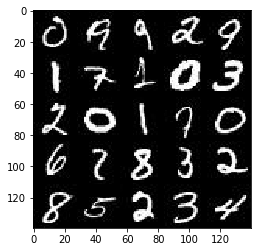

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

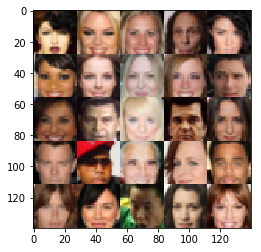

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learing_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print(flat.shape)
        logits = tf.layers.dense(flat, 1)
        #print(logits.shape)
        out = tf.sigmoid(logits)
        #print(out.shape)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train) as scope:
        fc1 = tf.layers.dense(z, 7*7*256)
        #print(fc1.shape)
        # Reshape
        x1 = tf.reshape(fc1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.nn.relu(x1)
        #print(x1.shape)
        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #print(x2.shape)
        # Ouput layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        #print(logits.shape)
        out = tf.tanh(logits)
        #print(out.shape)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    smooth = 0.1
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if(data_image_mode == 'RGB'):
        out_dim = 3
    else:
        out_dim = 1
    
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    # Inputs
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    print_every = 10
    show_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                # TODO: Train Model
                steps +=1

                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                #Step 2. Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_z = tf.random_uniform(minval=-1, maxval=1, shape=(25,z_dim),dtype=tf.float32)
                    show_generator_output(sess, 25, show_z, data_shape[3], data_image_mode)


        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)

    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.3332... Generator Loss: 0.0685
Epoch 1/2... Discriminator Loss: 2.1763... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.8796... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 2.2110... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.9038... Generator Loss: 1.1602


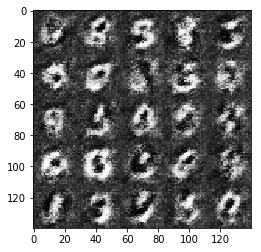

Epoch 1/2... Discriminator Loss: 1.6498... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.9840
Epoch 1/2... Discriminator Loss: 1.8988... Generator Loss: 0.2636


Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.6658... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.6150


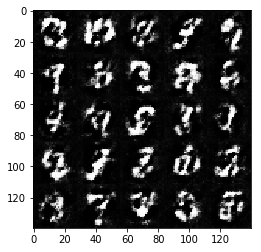

Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.8463


Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.8739
Epoch 1/2... Discriminator Loss: 1.4302... Generator Loss: 0.5931
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 1.0897
Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.5932


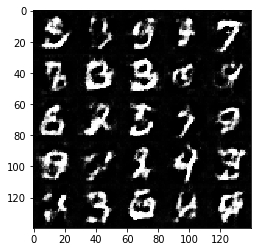

Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.8850
Epoch 1/2... Discriminator Loss: 1.8267... Generator Loss: 0.2930
Epoch 1/2... Discriminator Loss: 1.9572... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 1.5415... Generator Loss: 0.5433


Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.6634... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.5497


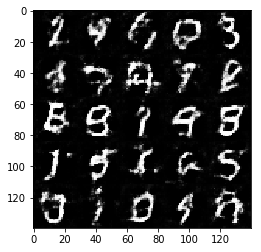

Epoch 1/2... Discriminator Loss: 1.9431... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 1.9151... Generator Loss: 0.2454
Epoch 1/2... Discriminator Loss: 1.6730... Generator Loss: 0.3470
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.3016


Epoch 1/2... Discriminator Loss: 1.5584... Generator Loss: 0.5375
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 0.1908
Epoch 1/2... Discriminator Loss: 1.8441... Generator Loss: 0.2881
Epoch 1/2... Discriminator Loss: 1.6051... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.9334


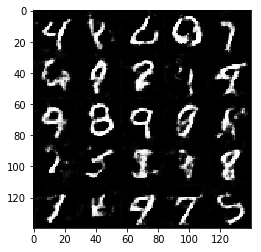

Epoch 1/2... Discriminator Loss: 1.6027... Generator Loss: 0.5722
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.4649
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 0.4311


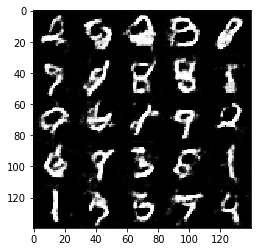

Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.4700
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.8015... Generator Loss: 0.2905


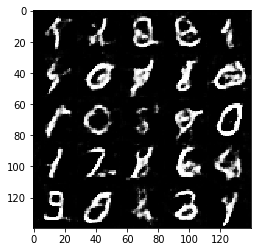

Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.3335
Epoch 1/2... Discriminator Loss: 1.7253... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 1.7922... Generator Loss: 0.2994
Epoch 1/2... Discriminator Loss: 1.5636... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 2.0347... Generator Loss: 0.2185


Epoch 1/2... Discriminator Loss: 1.8202... Generator Loss: 0.3156
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.6575... Generator Loss: 0.3998
Epoch 1/2... Discriminator Loss: 1.5897... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.5857... Generator Loss: 0.4106


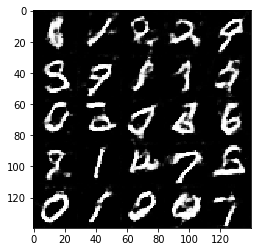

Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.5532
Epoch 1/2... Discriminator Loss: 1.5789... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.7699... Generator Loss: 0.2947


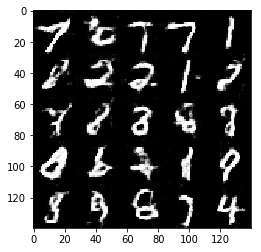

Epoch 1/2... Discriminator Loss: 1.6543... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.7568
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 0.5303


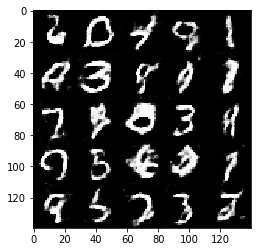

Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 0.3461
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.7593


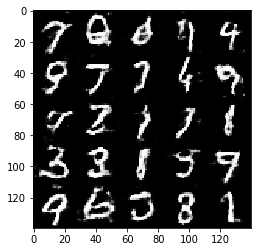

Epoch 1/2... Discriminator Loss: 1.5126... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.4970
Epoch 1/2... Discriminator Loss: 1.5765... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.5172


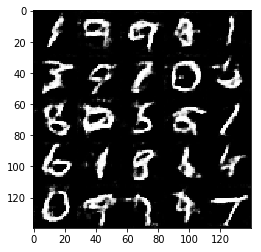

Epoch 1/2... Discriminator Loss: 1.8913... Generator Loss: 0.2553
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.5187
Epoch 1/2... Discriminator Loss: 1.6049... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.9217... Generator Loss: 0.2478
Epoch 1/2... Discriminator Loss: 2.1922... Generator Loss: 0.1915


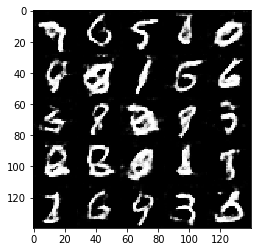

Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.6546... Generator Loss: 0.3475
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.5478
Epoch 1/2... Discriminator Loss: 1.5358... Generator Loss: 0.4317


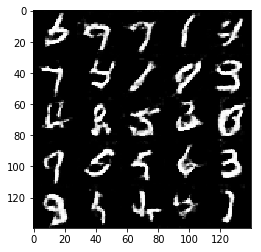

Epoch 1/2... Discriminator Loss: 1.4612... Generator Loss: 1.3888
Epoch 1/2... Discriminator Loss: 1.7042... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.5162
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.4583


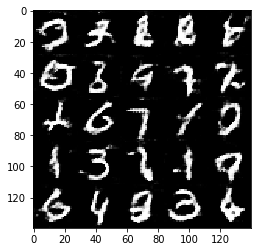

Epoch 1/2... Discriminator Loss: 1.5859... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.8213... Generator Loss: 0.2791
Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.3617


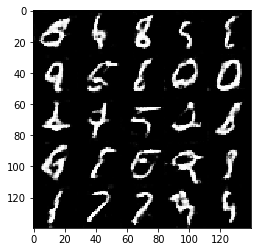

Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.8854
Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.4739
Epoch 1/2... Discriminator Loss: 1.9461... Generator Loss: 0.2517
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 1.6379... Generator Loss: 0.5800


Epoch 1/2... Discriminator Loss: 1.7023... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.3657
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 0.4905


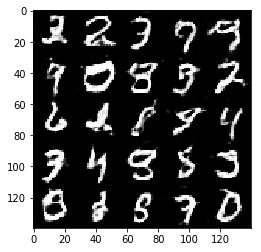

Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.6179
Epoch 1/2... Discriminator Loss: 2.0984... Generator Loss: 0.2137
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 0.4362
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.3193


Epoch 1/2... Discriminator Loss: 1.8470... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 1.9814... Generator Loss: 0.2369


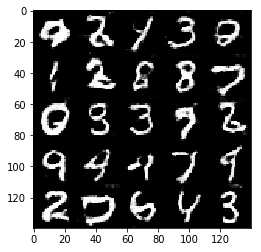

Epoch 1/2... Discriminator Loss: 1.8628... Generator Loss: 0.2669
Epoch 1/2... Discriminator Loss: 1.9972... Generator Loss: 0.2377
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.6720... Generator Loss: 0.4176
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 0.8881


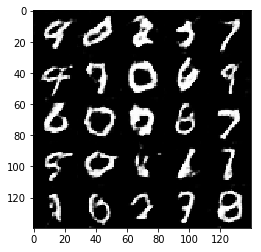

Epoch 1/2... Discriminator Loss: 1.7303... Generator Loss: 0.3169
Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.4038


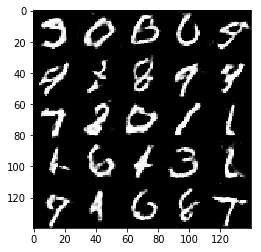

Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 2.1211... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 1.8987... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.9925... Generator Loss: 0.2357
Epoch 1/2... Discriminator Loss: 1.8413... Generator Loss: 0.2765


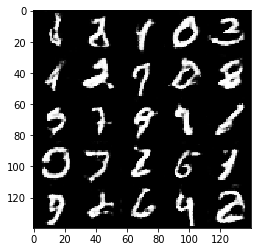

Epoch 1/2... Discriminator Loss: 1.7585... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 3.8360... Generator Loss: 0.0523
Epoch 1/2... Discriminator Loss: 1.9321... Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.4806


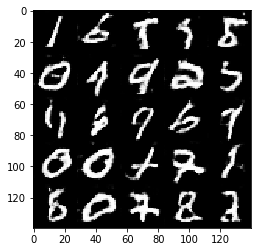

Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.8753... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 0.3784


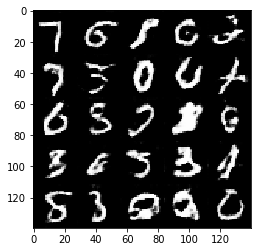

Epoch 1/2... Discriminator Loss: 1.6543... Generator Loss: 0.4086
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 0.3817
Epoch 1/2... Discriminator Loss: 1.8868... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 2.6173... Generator Loss: 0.1391
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.4395


Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.3992
Epoch 1/2... Discriminator Loss: 1.8888... Generator Loss: 0.2622
Epoch 1/2... Discriminator Loss: 1.9135... Generator Loss: 0.2708


Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.4432
Epoch 1/2... Discriminator Loss: 1.9185... Generator Loss: 0.2623
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.6929... Generator Loss: 0.3496


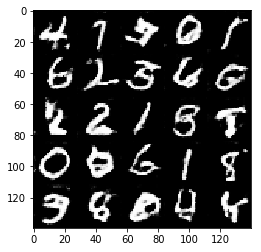

Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.8370... Generator Loss: 0.3267
Epoch 1/2... Discriminator Loss: 2.1262... Generator Loss: 0.2101


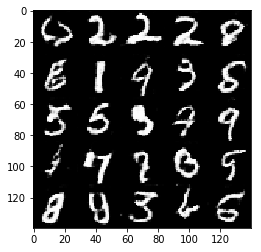

Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.3989
Epoch 1/2... Discriminator Loss: 1.9252... Generator Loss: 0.2544
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.8606... Generator Loss: 0.2855


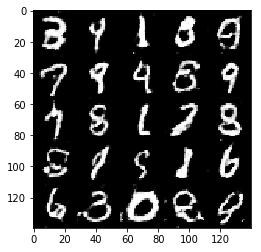

Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.8058... Generator Loss: 0.2927
Epoch 1/2... Discriminator Loss: 1.9169... Generator Loss: 0.2810
Epoch 1/2... Discriminator Loss: 1.6533... Generator Loss: 0.5420


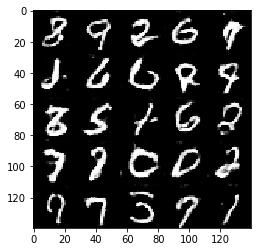

Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 2.1522... Generator Loss: 0.2163
Epoch 1/2... Discriminator Loss: 1.6252... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.1086
Epoch 1/2... Discriminator Loss: 2.0504... Generator Loss: 0.2271


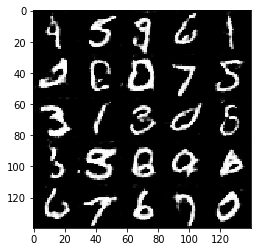

Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.6848
Epoch 2/2... Discriminator Loss: 1.6754... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 1.8793... Generator Loss: 0.2731


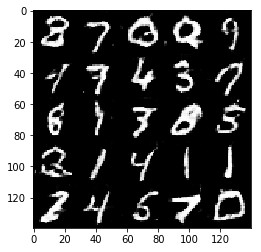

Epoch 2/2... Discriminator Loss: 1.4773... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.6628
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 2.0092... Generator Loss: 0.2619
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 0.4305


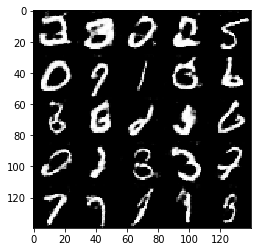

Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6015
Epoch 2/2... Discriminator Loss: 2.2502... Generator Loss: 0.1890
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.6789
Epoch 2/2... Discriminator Loss: 1.6939... Generator Loss: 2.1686
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.4683


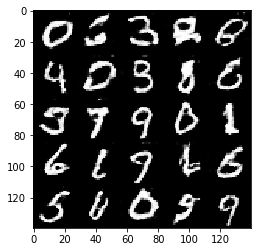

Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.4622
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.4248
Epoch 2/2... Discriminator Loss: 1.7167... Generator Loss: 0.3211
Epoch 2/2... Discriminator Loss: 2.1524... Generator Loss: 0.1920
Epoch 2/2... Discriminator Loss: 2.6003... Generator Loss: 0.1528


Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.1343... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 2.4564... Generator Loss: 0.1739
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 1.1575


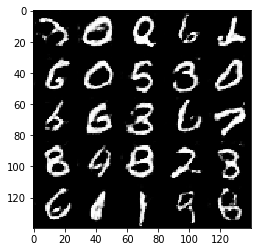

Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 2.1637... Generator Loss: 0.2394
Epoch 2/2... Discriminator Loss: 1.5988... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.9407... Generator Loss: 0.2720


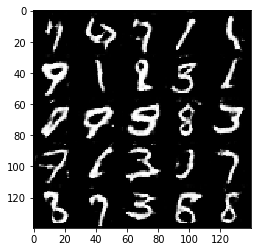

Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 1.9975... Generator Loss: 0.2496


Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.6624
Epoch 2/2... Discriminator Loss: 2.1692... Generator Loss: 0.1953
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 0.4148
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.4638
Epoch 2/2... Discriminator Loss: 1.8090... Generator Loss: 0.2927


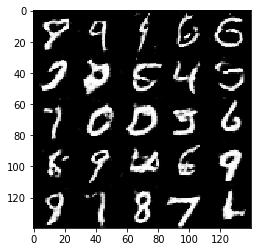

Epoch 2/2... Discriminator Loss: 1.5744... Generator Loss: 0.4201
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.6273


Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.4079
Epoch 2/2... Discriminator Loss: 2.1181... Generator Loss: 0.2375
Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.7965


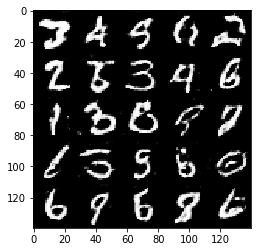

Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.6958... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 1.6174... Generator Loss: 0.3844
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.8165... Generator Loss: 0.3056


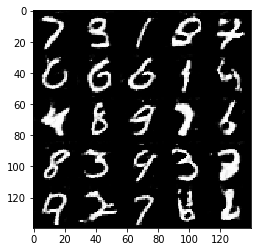

Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 2.1211... Generator Loss: 0.2300
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.9266... Generator Loss: 0.2716
Epoch 2/2... Discriminator Loss: 1.7831... Generator Loss: 0.3152


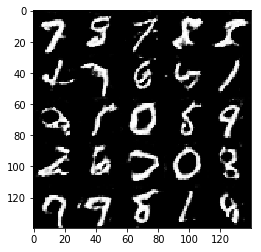

Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.7443... Generator Loss: 0.3197
Epoch 2/2... Discriminator Loss: 1.6295... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 1.7928... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 2.0035... Generator Loss: 0.2525


Epoch 2/2... Discriminator Loss: 2.0932... Generator Loss: 0.2271
Epoch 2/2... Discriminator Loss: 1.6075... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.6348... Generator Loss: 0.3576
Epoch 2/2... Discriminator Loss: 1.6739... Generator Loss: 0.3373
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 1.1219


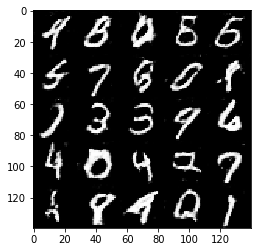

Epoch 2/2... Discriminator Loss: 2.5356... Generator Loss: 0.1650
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 2.4668... Generator Loss: 0.1400
Epoch 2/2... Discriminator Loss: 1.7834... Generator Loss: 0.3352


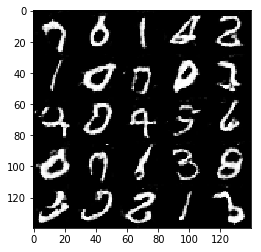

Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 0.3377
Epoch 2/2... Discriminator Loss: 2.9183... Generator Loss: 0.1243
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.4262... Generator Loss: 0.5467


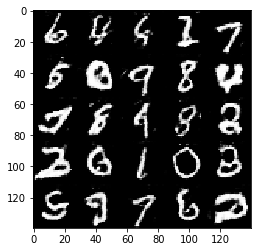

Epoch 2/2... Discriminator Loss: 1.9740... Generator Loss: 0.2500
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.6318
Epoch 2/2... Discriminator Loss: 2.0700... Generator Loss: 0.2239
Epoch 2/2... Discriminator Loss: 1.9973... Generator Loss: 0.2519
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.5547


Epoch 2/2... Discriminator Loss: 2.4053... Generator Loss: 0.1657
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 0.3994
Epoch 2/2... Discriminator Loss: 1.7501... Generator Loss: 0.3526
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.5424


Epoch 2/2... Discriminator Loss: 1.5975... Generator Loss: 0.4054
Epoch 2/2... Discriminator Loss: 1.6313... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 1.5586... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.4532
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.5451


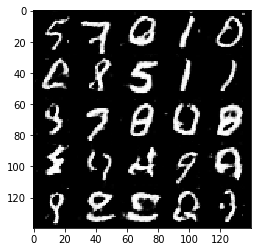

Epoch 2/2... Discriminator Loss: 1.6601... Generator Loss: 0.3846
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.4593
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.7482
Epoch 2/2... Discriminator Loss: 1.7597... Generator Loss: 0.3445
Epoch 2/2... Discriminator Loss: 2.9141... Generator Loss: 0.1121


Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 2.2763... Generator Loss: 0.1953
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 1.8412... Generator Loss: 0.2966


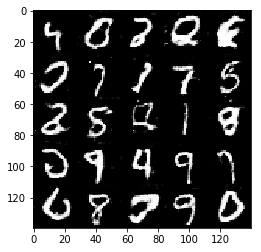

Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.4304
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 0.6026
Epoch 2/2... Discriminator Loss: 1.7451... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 1.8202... Generator Loss: 0.3042
Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 0.5670


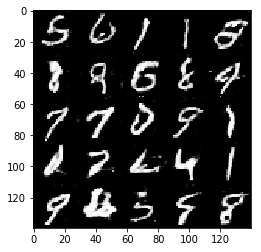

Epoch 2/2... Discriminator Loss: 1.6142... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.6448... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 1.8833... Generator Loss: 0.2803
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 2.1769... Generator Loss: 0.2120


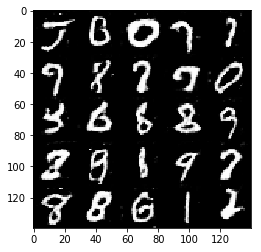

Epoch 2/2... Discriminator Loss: 1.7521... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.6759... Generator Loss: 0.3896
Epoch 2/2... Discriminator Loss: 1.9659... Generator Loss: 0.2623


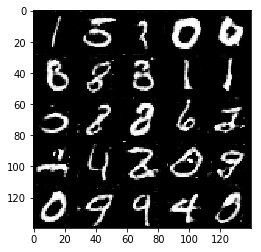

Epoch 2/2... Discriminator Loss: 1.5346... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.5663... Generator Loss: 0.4231
Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 2.6298... Generator Loss: 0.1538
Epoch 2/2... Discriminator Loss: 1.8738... Generator Loss: 0.2758


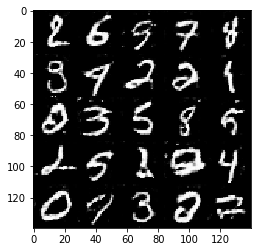

Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.5347
Epoch 2/2... Discriminator Loss: 1.7256... Generator Loss: 0.3236
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.6980... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.8777... Generator Loss: 0.3031


Epoch 2/2... Discriminator Loss: 1.6664... Generator Loss: 0.3663
Epoch 2/2... Discriminator Loss: 1.6259... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.4547
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.4987


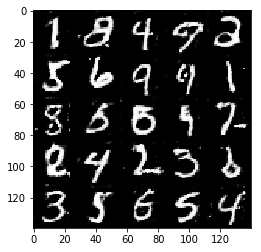

Epoch 2/2... Discriminator Loss: 2.1559... Generator Loss: 0.2193
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.3462
Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.4201
Epoch 2/2... Discriminator Loss: 2.3109... Generator Loss: 0.1957


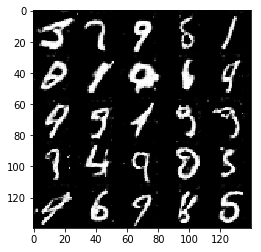

Epoch 2/2... Discriminator Loss: 1.7591... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.4471
Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 2.4940... Generator Loss: 0.1419
Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.4419


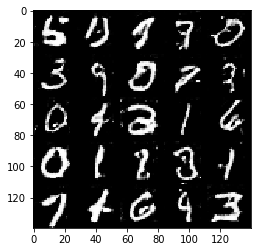

Epoch 2/2... Discriminator Loss: 1.8127... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 2.1404... Generator Loss: 0.2228
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.7193... Generator Loss: 0.3213
Epoch 2/2... Discriminator Loss: 1.7096... Generator Loss: 0.3393


Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.4911
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.5930
Epoch 2/2... Discriminator Loss: 1.7721... Generator Loss: 0.3004
Epoch 2/2... Discriminator Loss: 1.9880... Generator Loss: 0.2422
Epoch 2/2... Discriminator Loss: 1.5264... Generator Loss: 0.4717


Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.3564
Epoch 2/2... Discriminator Loss: 1.6762... Generator Loss: 0.3286
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 1.0535
Epoch 2/2... Discriminator Loss: 1.6092... Generator Loss: 0.3951
Epoch 2/2... Discriminator Loss: 2.3222... Generator Loss: 0.1787


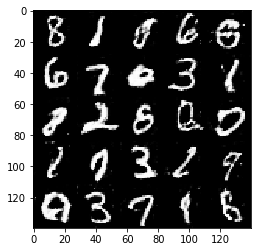

Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 0.6188
Epoch 2/2... Discriminator Loss: 2.0450... Generator Loss: 0.2541
Epoch 2/2... Discriminator Loss: 2.2109... Generator Loss: 0.1953


Epoch 2/2... Discriminator Loss: 2.4615... Generator Loss: 0.1768
Epoch 2/2... Discriminator Loss: 2.0095... Generator Loss: 0.2326
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.5706... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 1.1930


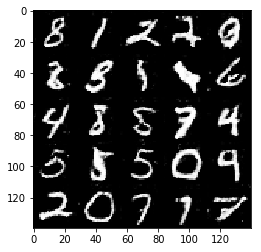

Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.8564... Generator Loss: 0.3088
Epoch 2/2... Discriminator Loss: 1.8512... Generator Loss: 0.2808
Epoch 2/2... Discriminator Loss: 1.6422... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.6868... Generator Loss: 0.3572


Epoch 2/2... Discriminator Loss: 1.2517... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.5596
Epoch 2/2... Discriminator Loss: 1.3183... Generator Loss: 0.5300
Epoch 2/2... Discriminator Loss: 1.7002... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.5368


Epoch 2/2... Discriminator Loss: 1.6682... Generator Loss: 0.3894
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 1.8040... Generator Loss: 0.3399
Epoch 2/2... Discriminator Loss: 1.7444... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 2.4595... Generator Loss: 0.1552


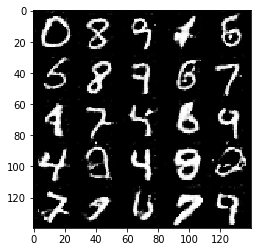

Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.5738
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.6757... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 1.5807


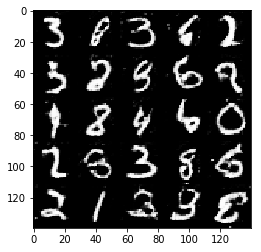

Training finished.


In [13]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
print('Training finished.')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.1571... Generator Loss: 0.0322
Epoch 1/1... Discriminator Loss: 3.1095... Generator Loss: 0.1234
Epoch 1/1... Discriminator Loss: 2.6373... Generator Loss: 0.1882
Epoch 1/1... Discriminator Loss: 2.3408... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 2.2156... Generator Loss: 0.6852


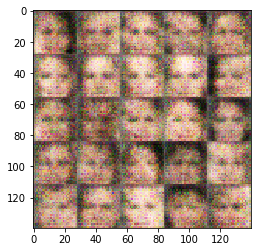

Epoch 1/1... Discriminator Loss: 2.4051... Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 2.1920... Generator Loss: 0.2120
Epoch 1/1... Discriminator Loss: 1.9616... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.8420... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.8251... Generator Loss: 0.4806


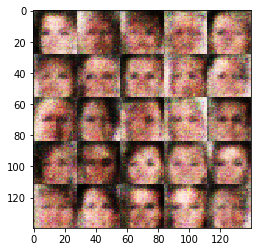

Epoch 1/1... Discriminator Loss: 1.8368... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.8036... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.8079... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.8012... Generator Loss: 0.3602


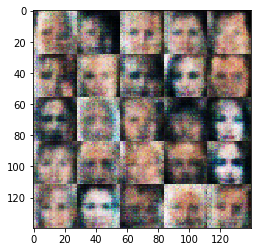

Epoch 1/1... Discriminator Loss: 1.8394... Generator Loss: 0.2901
Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 0.4216


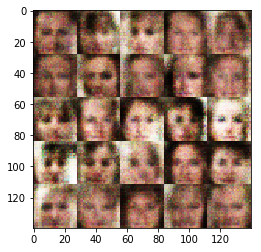

Epoch 1/1... Discriminator Loss: 1.6261... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.6558... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.7113... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.5623


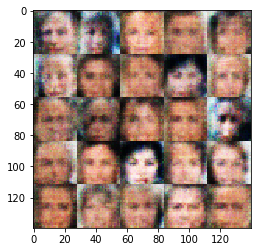

Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5196


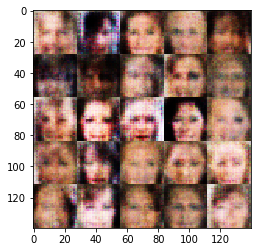

Epoch 1/1... Discriminator Loss: 1.6458... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.5689


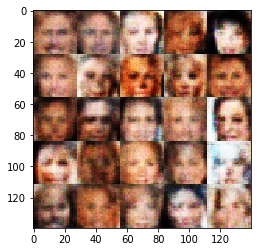

Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.5420


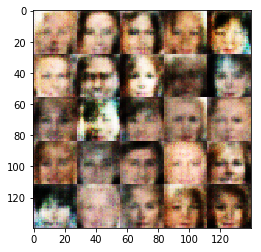

Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5993


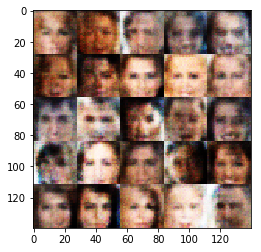

Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.6946... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6578


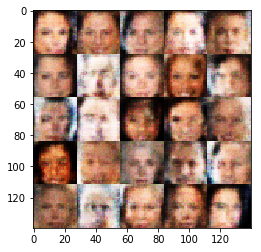

Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7394


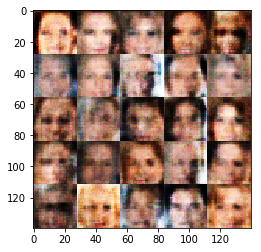

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.7429


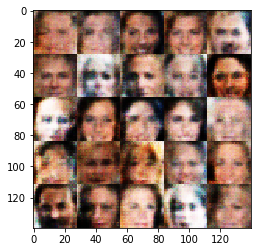

Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6149


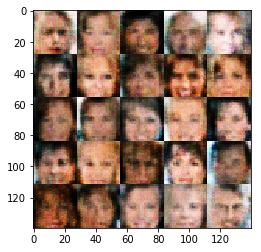

Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.6107


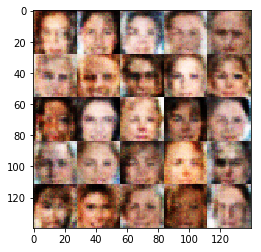

Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6447


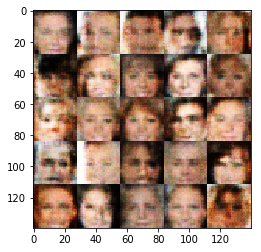

Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7391


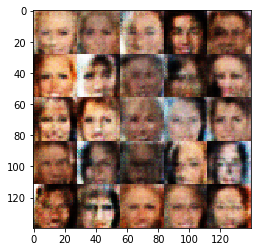

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5975


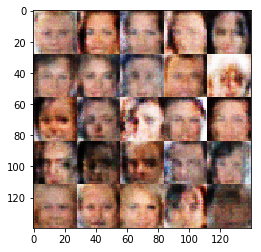

Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7210


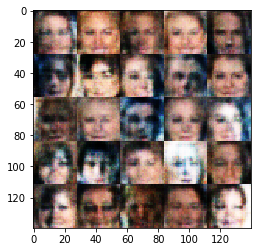

Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6749


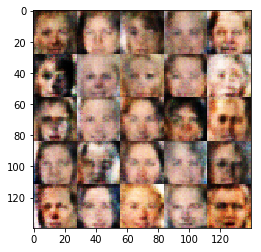

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6868


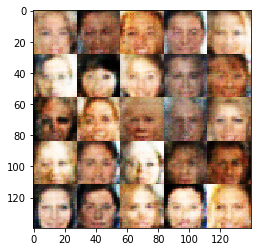

Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.6698


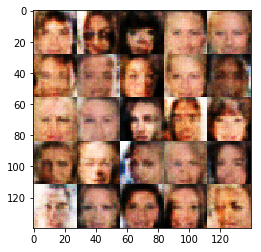

Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.6837


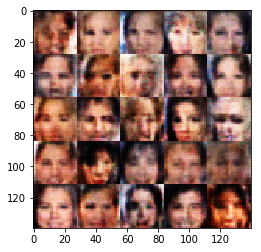

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7082


Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6273


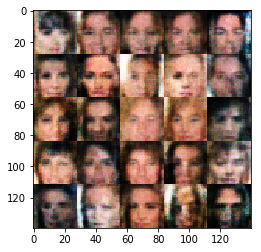

Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7309


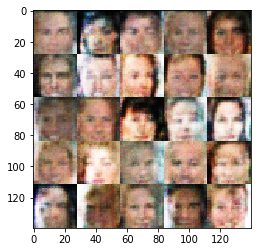

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7670


Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6790


Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6601


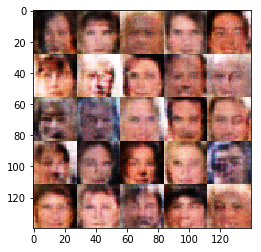

Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.6237


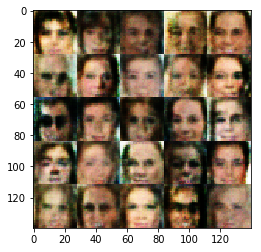

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6791


Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6563


Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7461


Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7461


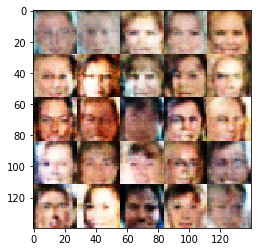

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7275


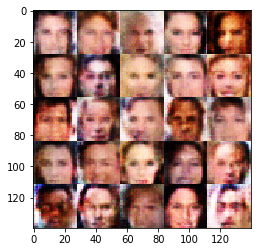

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6088


Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7783


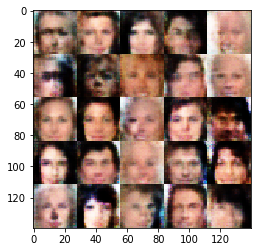

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8605


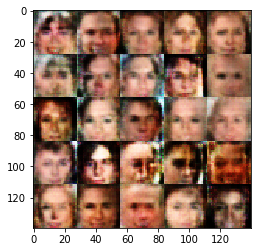

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 1.0055


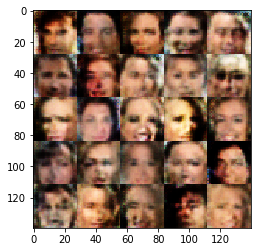

Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6548


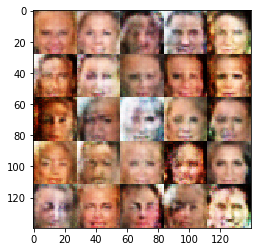

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7026


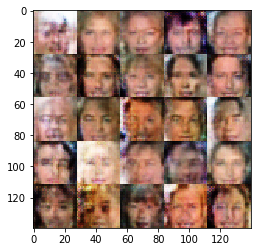

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7542


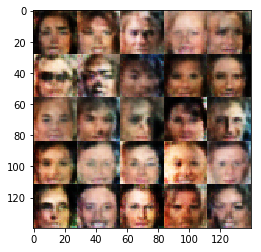

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.8117


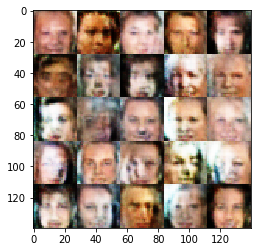

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6388


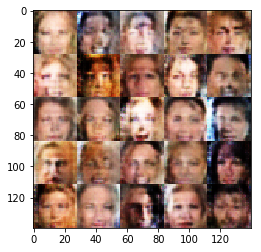

Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5863


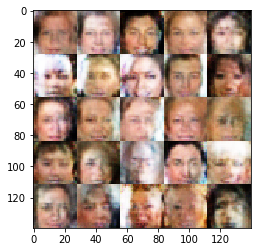

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7549


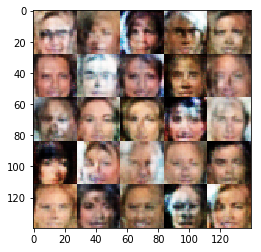

Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8576


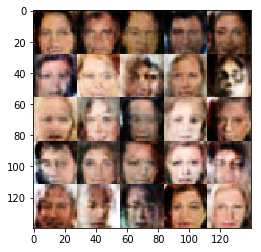

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7616


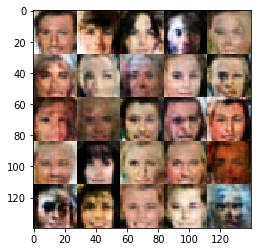

Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7071


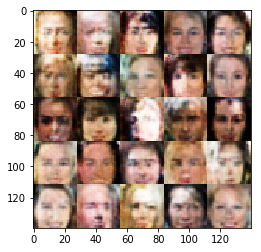

Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.0655


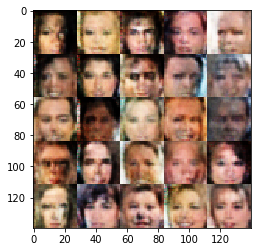

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7642


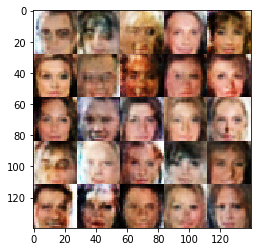

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7104


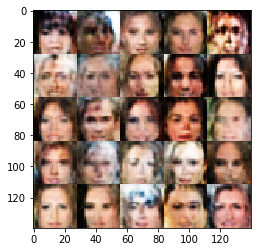

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6866


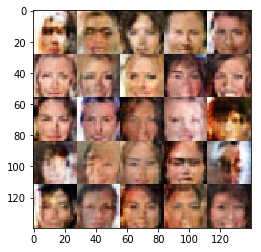

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6537


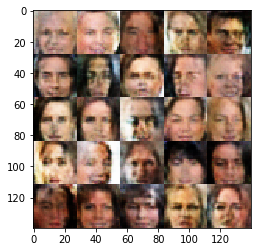

Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7158


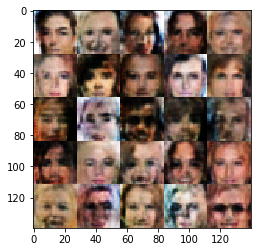

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6783


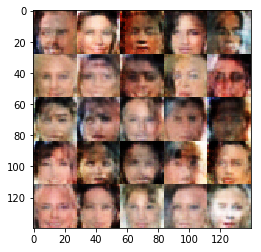

Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7172


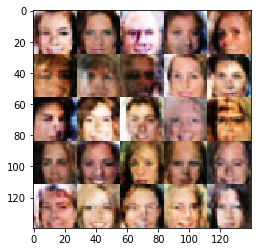

Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6857


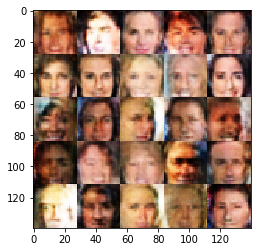

Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8397


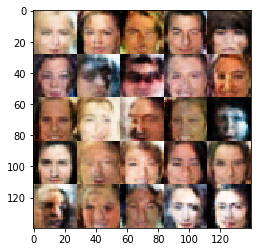

Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7403


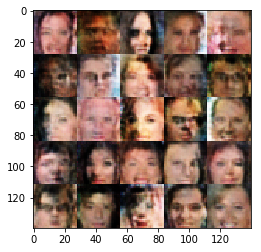

Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5868


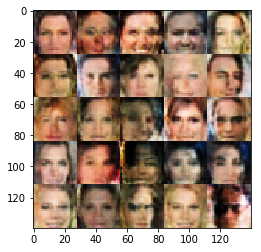

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6677


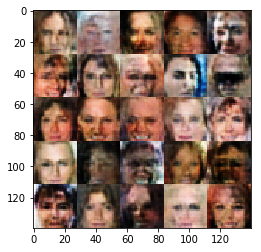

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7043


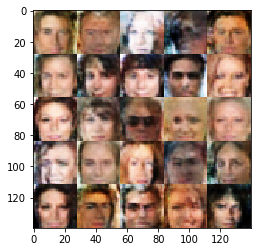

Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7279


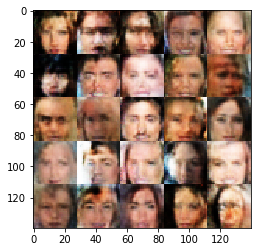

Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6707


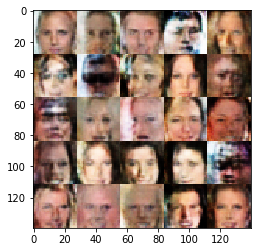

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6087


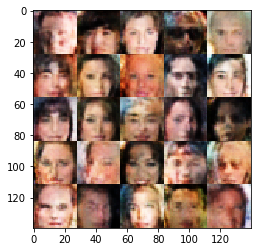

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6921


Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7233


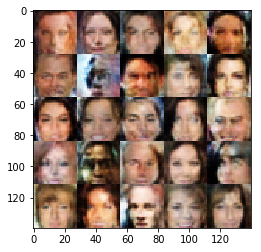

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6671


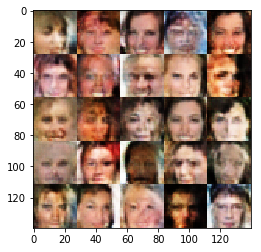

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6802


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 50
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.